# Land Cover Classification

The purpose of this process is to train a simple land cover classification model that is capable of classifing 5 different classes given a set of satellite imageries. In the following, there are a few blocks of code where in the first block the required libraries are imported. Next, the training set is built followed by test set preparation block. (The trainig set and test set preparation blocks could be merged into a single block to have less code, however, having two separate blocks makes it easier for the reader to follow the process so it was decided to keep the two-block structure.) Then, the training set is read in and a simple land cover classification model is trained that is capable of detecting 5 different classes. Finally, the model is applied to the created test set and the result is shown on the screen.

In [2]:
import os
import numpy
import pandas
import pathlib
from PIL import Image

import sys
import time
import pickle
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

## Training Set

The following block creates a CSV file with 5 columns of red, green, blue, infrared bands and the last one being class type. The class column can hold 5 different letters including ___b___, ___c___, ___f___, ___t___, ___w___ which stand for barren (land), cloud, farm (land), tree, and water. It reads the images from a directory convert them to numpy arrays and saves them as a CSV file. For more details on the structre of the file system of this project see the land cover classification gitlab page of this project. 

In [3]:

# The following list holds the first letter of each class type.
landType  = ["b", "c", "f", "t", "w"]
dataFrameList = [] 

# Iterate through each land type and take the intensity values of the 4 different bands of each land type
for ltype in landType:
    # The path to each image of each class is given in the following lines ()
    redPath   = pathlib.Path("trainImage/" + ltype + "_Sentinel2_B04.png")
    greenPath = pathlib.Path("trainImage/" + ltype + "_Sentinel2_B03.png")
    bluePath  = pathlib.Path("trainImage/" + ltype + "_Sentinel2_B02.png")
    irPath    = pathlib.Path("trainImage/" + ltype + "_Sentinel2_B08.png")
    
    # Change the heigh and width order from (h, w) to (w, h)
    redImage   = numpy.moveaxis(numpy.array(Image.open(redPath)), 1, 0)
    greenImage = numpy.moveaxis(numpy.array(Image.open(greenPath)), 1, 0)
    blueImage  = numpy.moveaxis(numpy.array(Image.open(bluePath)), 1, 0)
    irImage    = numpy.moveaxis(numpy.array(Image.open(irPath)), 1, 0)
    
    # Convert the 2-dimension arrays to 1-dimension arrays
    redBand   = redImage.flatten().astype(int)
    greenBand = greenImage.flatten().astype(int)
    blueBand  = blueImage.flatten().astype(int)
    irBand    = irImage.flatten().astype(int)
    
    # Stack the numpy arrays and convert them to a dataframe
    label   = numpy.repeat(ltype, redImage.size).astype(str)
    stacked = numpy.column_stack((redBand, greenBand, blueBand, irBand))
    dataFrame = pandas.DataFrame(stacked, columns = ["red", "green", "blue", "IR"])
    
    # For class column we create a separate series and then append it to the final data frame.
    dataFrame["class"] = pandas.Series(label)
    dataFrameList.append(dataFrame)
finalTrainFrame = pandas.concat(dataFrameList)
finalTrainFrame.to_csv("trainSet.csv", index = False)


## Test Set

The following block prepares one test set in the form of a CSV file with 4 different columns of red, green, blue and infrared intensities. The following code snipet is, also, very similar to the code above with the exception that it does not create a class column.


In [4]:
# Here a single test file name should be given
landType  = ["test3"]
testFrameList = [] 

for ltype in landType:
    redPath   = pathlib.Path("testImage/" + ltype + "_Sentinel2_B04.png")
    greenPath = pathlib.Path("testImage/" + ltype + "_Sentinel2_B03.png")
    bluePath  = pathlib.Path("testImage/" + ltype + "_Sentinel2_B02.png")
    irPath    = pathlib.Path("testImage/" + ltype + "_Sentinel2_B08.png")
    
    redImage   = numpy.moveaxis(numpy.array(Image.open(redPath)), 1, 0)
    greenImage = numpy.moveaxis(numpy.array(Image.open(greenPath)), 1, 0)
    blueImage  = numpy.moveaxis(numpy.array(Image.open(bluePath)), 1, 0)
    irImage    = numpy.moveaxis(numpy.array(Image.open(irPath)), 1, 0)
    
    # Take the width and height of our test image to be used in the last block for visualisation
    testImgDims= redImage.shape
    
    redBand   = redImage.flatten().astype(int)
    greenBand = greenImage.flatten().astype(int)
    blueBand  = blueImage.flatten().astype(int)
    irBand    = irImage.flatten().astype(int)
    
    label   = numpy.repeat(ltype, redImage.size).astype(str)
    stacked = numpy.column_stack((redBand, greenBand, blueBand, irBand))
    dataFrame = pandas.DataFrame(stacked, columns = ["red", "green", "blue", "IR"])
    testFrameList.append(dataFrame)
finalTestFrame = pandas.concat(testFrameList)
finalTestFrame.to_csv("testSet.csv", index = False)


## Model Training

The following block trains a clustering model to assign the most likely class type to each pixel based on the provided intensity values of the provided four bands. This model can take a subsample of the entire training set (i.e trainingSize variable in the code) for training the model. Note that the members of this subsample are selected ___randomly___ at each run. So, the final trained models at the end of each run are different with one another, however, this difference should be insignificant since the pixel intensities of the water of the total training sample are quite similar to eachother. The impact of random selection may be more pronounced in barren land pixels as the training image for barren land varies at different locations of the image. Once the model is trained it will be saved/pickled under the name "model.pkl" in the working directory.

In [7]:
# Reading in the data.

df  = pandas.read_csv('trainSet.csv')

# This variable shows that the first N pixels of each class type will be used for training purpose. 
# By default it is set to 100. Also, it is where the random selection happens. If the user does not
# wish the random selection behavior one can dimply remove the ".sample(frac = 1)" method in the 
# following lines.
trainingSize = 100

dataFrameB = df.loc[df["class"] == "b"].sample(frac = 1)[:trainingSize]
dataFrameC = df.loc[df["class"] == "c"].sample(frac = 1)[:trainingSize]
dataFrameF = df.loc[df["class"] == "f"].sample(frac = 1)[:trainingSize]
dataFrameT = df.loc[df["class"] == "t"].sample(frac = 1)[:trainingSize]
dataFrameW = df.loc[df["class"] == "w"].sample(frac = 1)[:trainingSize]

# The final training data frame is created in this line.
equalFrame = pandas.concat([dataFrameB, dataFrameC, dataFrameF, dataFrameT, dataFrameW])

# Select the first 4 columns as features!
x = equalFrame.iloc[:, [0, 1, 2, 3]].values.astype(int)

# Select the class column as class feature
y = equalFrame.iloc[:, -1].values.astype(str)


#   Creating train and test sets.

xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 0.25, random_state = 0)

#   Standardize and Normalize the data sets.

sc = StandardScaler()

xTrain = sc.fit_transform(xTrain)
xTest  = sc.transform(xTest)

classifier = KNeighborsClassifier(n_neighbors = 10, metric = 'minkowski', p = 2)
classifier.fit(xTrain, yTrain)

filename = 'model.pkl'
pickle.dump(classifier, open(filename, 'wb'))


C:\Users\nbalafka\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\nbalafka\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\nbalafka\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


# Visualization

The following block of code will use the trained model from the previous block to do predictions on the prepared test data set. Finally, the resulting land cover classification map will be shown.

C:\Users\nbalafka\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\nbalafka\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


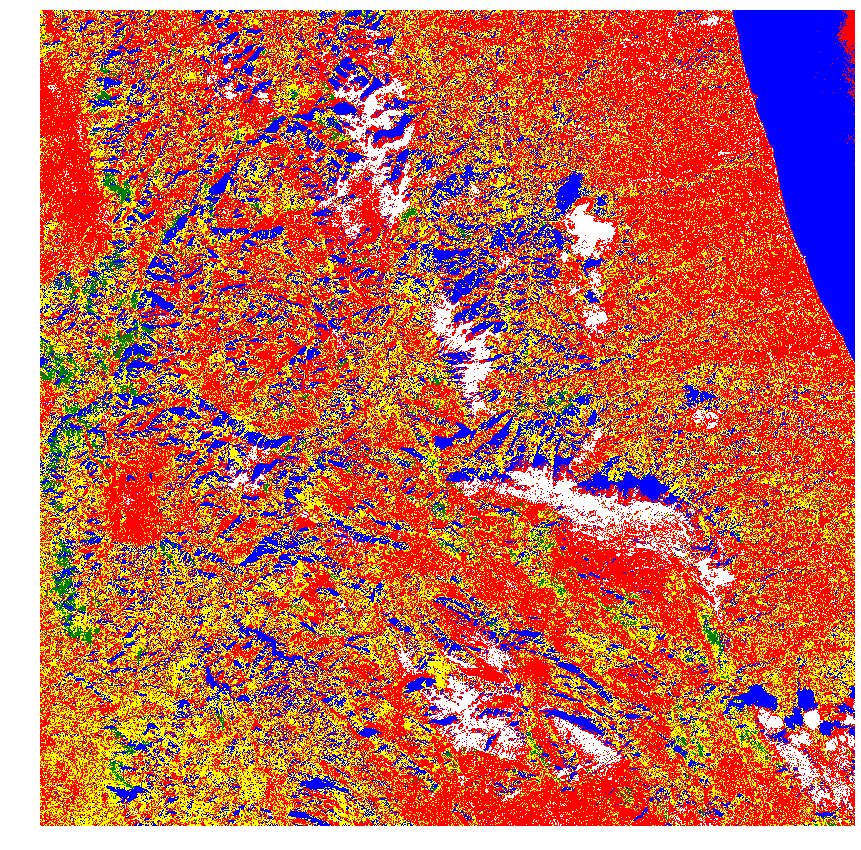

In [8]:

df2 = pandas.read_csv('testSet.csv')
x2  = df2.iloc[:, [0, 1, 2, 3]].values

sc  = StandardScaler()

xTest2  = sc.fit_transform(x2)

y_pred2 = classifier.predict(xTest2)

y_pred2[y_pred2 == 'b'] = 0
y_pred2[y_pred2 == 'c'] = 1
y_pred2[y_pred2 == 'f'] = 2
y_pred2[y_pred2 == 't'] = 3
y_pred2[y_pred2 == 'w'] = 4

# This line will reshape the predicted array to input test image shape (taken from the previous block) for 
# visualization purposes. 
y_pred2 = y_pred2.reshape(testImgDims)

cmap    = colors.ListedColormap(['r','white','yellow', 'g','b'])

fig, ax = plt.subplots(figsize=(15, 15))
plt.axis('off')
# The image needs to be rotated and fliped to match the true image of the region.
ax.imshow(numpy.flipud(numpy.rot90(y_pred2.astype('float32'))), cmap = cmap)

fig.savefig('segmentedMap.png', bbox_inches = 'tight')